# Evaluating Appointment Rules with Python  🗓️

In this session, we consider **Dr. Miller’s Practice** as our case study. Dr. Miller is a private practitioner in a remote village who schedules appointments for her patients in the morning (from 9:00 AM to 11:30 PM).

**Scenario Details:**
- **Total Patients (N):** 15  
- **Appointment Slot Length (d):** 10 minutes  
- **Numper of slots (T):** 150 minutes / 10 minutes = 15
- **Service Times:** Exponentially distributed with a **mean** of 10 minutes (i.e., λ = 1/10 per minute).

Due to the stochastic nature of service times, the actual schedule may lead to patient waiting times, idle time for Dr. Miller, and possible overtime if the session extends beyond 11:30 PM.

In this notebook you will:
- **Model a schedule in Python** using dictionaries.
- **Evaluate a given schedule** using custom functions that compute performance measures such as waiting time and the overall objective function.
- **Visualize the schedule** and objective value via a dashboard.
- **Experiment with parameters:** Modify the schedule, service rate, and weights to observe how these changes affect the performance.

Let’s begin by modeling a schedule.

## (1) Define a Schedule and Plot It

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1}


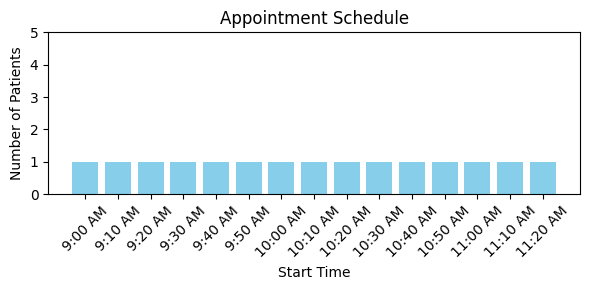

In [4]:
import matplotlib.pyplot as plt

# Define an example schedule as a dictionary
# Here, keys represent slot indices and values the number of patients scheduled in that slot.
x_t = {t: 1 for t in range(1, 16)}  # For example, 15 slots with 0 patients initially
print(x_t)
# Define the start-times for each slot (adjust if necessary)
start_times = {
    1: "9:00 AM", 2: "9:10 AM", 3: "9:20 AM", 4: "9:30 AM", 5: "9:40 AM",
    6: "9:50 AM", 7: "10:00 AM", 8: "10:10 AM", 9: "10:20 AM", 10: "10:30 AM",
    11: "10:40 AM", 12: "10:50 AM", 13: "11:00 AM", 14: "11:10 AM", 15: "11:20 AM"
}

# Define a function to plot the schedule
def plot_schedule(schedule, start_times):
    """
    Plots the appointment schedule as a bar plot.
    
    Parameters:
      - schedule (dict): Dictionary with slot indices as keys and number of patients as values.
      - start_times (dict): Dictionary with slot indices as keys and corresponding start time labels.
    """
    # Sort slots to ensure correct ordering.
    slots = sorted(schedule.keys())
    labels = [start_times.get(slot, f"Slot {slot}") for slot in slots]
    values = [schedule[slot] for slot in slots]
    
    plt.figure(figsize=(6, 3))
    plt.bar(labels, values, color='skyblue')
    plt.xlabel("Start Time")
    plt.ylabel("Number of Patients")
    plt.ylim([0,5])
    plt.title("Appointment Schedule")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot the initial (empty) schedule
plot_schedule(x_t, start_times)


## (2) Modeling the Schedule and Evaluating Performance

In addition to representing the schedule, we now need to evaluate its performance on three key measures:
- **Average Waiting Time:** The average delay experienced by patients before service begins.
- **Total Idle Time:** The cumulative time the doctor is idle (waiting for the next scheduled slot when no patients are present).
- **Mean Makespan:** The time at which the last patient is finished (i.e. the overall length of the service session).

The objective function for the outpatient scheduling model is given by:

$$
\min_{x} \quad C(x) = \alpha_{w}\,W(x) + \alpha_{I}\,I(x) + \alpha_{L}\,L(x)
$$

where:
- $W(x)$ is the expected waiting time,
- $I(x)$ is the expected idle time,
- $L(x)$ is the expected overtime (lateness), which we compute as the excess of the makespan over the scheduled finish time.

For our exercise we use:
- $\alpha_{w} = 1.0$
- $\alpha_{I} = 1.0$
- $\alpha_{L} = 2.0$

Below, we first simulate a schedule to compute these measures, and then we evaluate an overall objective function.


In [5]:
import math

def determine_probabilities(x_t, N, T, d, mu):
    """
    Computes the probabilities of having a given number of patients waiting at each slot,
    based on a Poisson process for service completions.

    Parameters:
        x_t (dict): The schedule dictionary mapping each slot t to the number of patients assigned.
        N (int): Total number of patients.
        T (int): Total number of slots.
        d (float): Length of one appointment slot (in minutes).
        mu (float): Service rate (per minute); mean service time = 1/mu.
    
    Returns:
        p (dict): A dictionary containing probability distributions for each slot:
            p[t]["minus"][j] = probability that j patients are waiting just before slot t starts.
            p[t]["plus"][j]  = probability that j patients are waiting just after patients are scheduled in slot t.
            Note: The recursion computes these probabilities for slots 1 to T. 
                  For slot T+1 (used later in lateness), the probabilities are computed in the last iteration.
    """
    
    # Compute Poisson probabilities for exactly i service completions in a period of length d.
    # a[i] = P(exactly i completions in time d)
    a = {i: (((mu * d) ** i) / math.factorial(i)) * math.exp(-mu * d) for i in range(N + 1)}
    
    # Compute cumulative probabilities:
    # b[i] = P(at least i completions in time d)
    b = {i: 1 - sum(a[j] for j in range(0, i)) for i in range(N + 1)}
    
    # Initialize the probability dictionaries for each slot t.
    # For each slot t, we maintain:
    #   p[t]["minus"][j]: Probability that j patients are waiting immediately before the start of slot t.
    #   p[t]["plus"][j]:  Probability that j patients are waiting immediately after arrivals are added at slot t.
    p = {t: {"minus": {j: 0.0 for j in range(N + 1)},
             "plus":  {j: 0.0 for j in range(N + 1)}}
         for t in range(1, T + 2)}
    
    # At the start of the first slot, no patients are waiting.
    p[1]["minus"][0] = 1.0

    # Iterate over slots 1 to T-1 to update the waiting probabilities.
    for t in range(1, T+1):
        # First, update the "plus" probabilities for slot t.
        # When x_t[t] patients arrive at slot t, the waiting state shifts:
        # p[t]["plus"][j] = probability that (j - x_t[t]) patients were waiting before arrivals,
        # if (j - x_t[t]) is non-negative; otherwise, 0.
        for j in range(0, N + 1):
            if j - x_t[t] >= 0:
                p[t]["plus"][j] = p[t]["minus"][j - x_t[t]]
            else:
                p[t]["plus"][j] = 0.0

        # Next, compute the "minus" probabilities for the next slot (t+1)
        # based on the service completions during slot t.
        for j in range(0, N + 1):
            if j == 0:
                # For j = 0 waiting patients at the beginning of slot (t+1),
                # sum over all possible states at the end of slot t weighted by
                # the probability of having at least i completions.
                p[t + 1]["minus"][0] = sum(p[t]["plus"][i] * b[i] for i in range(0, N + 1))
            else:
                # For j >= 1, compute the probability that exactly j patients remain waiting
                # by summing over all states where the difference (i - j) completions occur.
                p[t + 1]["minus"][j] = sum(p[t]["plus"][i] * a[i - j] for i in range(j, N + 1))
    
    return p


def W(x_t, N, T, d, mu):
    """
    Computes the average waiting time per patient using the determined probabilities.
    
    The waiting time for each patient in a slot is modeled as:
      (j + i - 1) / mu,
    where:
      - j: the number of patients waiting at the beginning of the slot,
      - i: the position of the patient within the slot (starting at 1).
    This is weighted by the probability of having j patients waiting at that slot.
    
    Parameters:
        x_t (dict): The schedule dictionary.
        N (int): Total number of patients.
        T (int): Total number of slots.
        d (float): Appointment slot length.
        mu (float): Service rate (per minute).
    
    Returns:
        avg_waiting (float): The average waiting time per patient.
    """
    p = determine_probabilities(x_t, N, T, d, mu)
    total_waiting = 0.0
    # Loop over each slot t
    for t in range(1, T + 1):
        # For each patient scheduled in slot t (i from 1 to x_t[t])
        for i in range(1, x_t[t] + 1):
            # Sum over all possible waiting queue lengths j (0 to N)
            for j in range(0, N + 1):
                # (j + i - 1) / mu represents the waiting time experienced by the patient.
                total_waiting += (j + i - 1) * (1 / mu) * p[t]["minus"][j]
    
    avg_waiting = total_waiting / N
    return avg_waiting


def M(x_t, N, T, d, mu):
    """
    Computes the mean makespan of the schedule, i.e., the expected finish time of the last patient.
    
    The makespan is computed as:
        (t_tilde - 1)*d + Expected additional delay in the last slot,
    where t_tilde is the last slot with scheduled patients and the delay is estimated from the 
    "plus" probabilities in that slot.
    
    Parameters:
        x_t (dict): The schedule dictionary.
        N (int): Total number of patients.
        T (int): Total number of slots.
        d (float): Appointment slot length.
        mu (float): Service rate (per minute).
    
    Returns:
        makespan (float): The expected finish time (in minutes).
    """
    p = determine_probabilities(x_t, N, T, d, mu)
    # Identify the last slot with at least one scheduled patient.
    t_tilde = max([t for t in x_t.keys() if x_t[t] > 0])
    # The scheduled finish time of the last used slot is (t_tilde-1)*d.
    # Add the expected additional delay from that slot based on the "plus" probabilities.
    expected_delay = sum((j / mu) * p[t_tilde]["plus"][j] for j in range(1, N + 1))
    makespan = (t_tilde - 1) * d + expected_delay
    return makespan


def I(x_t, N, T, d, mu):
    """
    Computes the total idle time for the doctor.
    
    Idle time is defined as the difference between the makespan of the schedule and the
    total effective service time (which is N/mu in expectation).
    
    Parameters:
        x_t (dict): The schedule dictionary.
        N (int): Total number of patients.
        T (int): Total number of slots.
        d (float): Appointment slot length.
        mu (float): Service rate (per minute).
    
    Returns:
        idle_time (float): The total idle time (in minutes).
    """
    makespan = M(x_t, N, T, d, mu)
    expected_service_time = N / mu
    idle_time = makespan - expected_service_time
    return idle_time


def L(x_t, N, T, d, mu):
    """
    Computes the expected lateness (overtime) of the schedule.
    
    Lateness is defined as the expected waiting time beyond the final scheduled slot.
    It is computed using the probabilities at slot T+1 (i.e., after processing all scheduled slots).
    
    Parameters:
        x_t (dict): The schedule dictionary.
        N (int): Total number of patients.
        T (int): Total number of slots.
        d (float): Appointment slot length.
        mu (float): Service rate (per minute).
    
    Returns:
        lateness (float): The expected overtime (in minutes).
    """
    p = determine_probabilities(x_t, N, T, d, mu)
    # Sum the expected additional waiting time in the extra slot (T+1).
    lateness = sum(p[T + 1]["minus"][j] * (j / mu) for j in range(1, N + 1))
    return lateness

def evaluate_schedule(x_t, N, T, d, mu, alpha_w=1.0, alpha_I=1.0, alpha_L=2.0):
    """
    Computes the weighted objective value of the schedule.
    Parameters:
        x_t (dict): The schedule dictionary.
        N (int): Total number of patients.
        T (int): Total number of slots.
        d (float): Appointment slot length in minutes.
        mu (float): Service rate (per minute).
        alpha_w(float): Weight for waiting time.
        alpha_I(float): Weight for idle time.   
        alpha_L(float): Weight for lateness/overtime.
    
    """
    waiting_time = W(x_t, N, T, d, mu)
    idle_time = I(x_t, N, T, d, mu)
    makespan = M(x_t, N, T, d, mu)
    lateness = L(x_t, N, T, d, mu)
    weighted_objective_value = alpha_w * waiting_time + alpha_I * idle_time + alpha_L * lateness

    print("The expected waiting time is", round(waiting_time, 2), "minutes.")
    print("The expected makespan is", round(makespan, 2), "minutes.")
    print("The expected idle time is", round(idle_time, 2), "minutes.")
    print("The expected lateness is", round(lateness, 2), "minutes.")

    print("The weighted objective value is", round(weighted_objective_value, 2))

# Print the computed performance measures using sample parameters.
# Here, N=15, T=15, d=10 minutes, mu=1/10 (i.e., mean service time = 1 minute) are used for demonstration.
# You might want to adjust these parameters (e.g., mu=1/10 for a 10-minute average service time).
# The weights for the objective value are alpha_w=1.0, alpha_I=1.0, alpha_L=2.0.
evaluate_schedule(x_t, 15, 15, 10, 1/10, 1, 1, 2)

The expected waiting time is 14.29 minutes.
The expected makespan is 173.89 minutes.
The expected idle time is 23.89 minutes.
The expected lateness is 24.92 minutes.
The weighted objective value is 88.02


You can see that despite the expected treatment duration being 10 minutes and scheduling 1 patient per interval, the doctor can expect to work overtime.

## (3) Analyze and Evaluate Different Appointment Rules

Now that you have defined the functions `evaluate_schedule` and `plot_schedule`, it's time to experiment with different scheduling rules and parameter settings. Your objective is to understand how the schedule's performance—particularly the expected lateness—changes under various appointment policies.

**Instructions:**
- Use the `evaluate_schedule` function to compute the objective value and performance measures for each of the following scenarios.
- Use the `plot_schedule` function to visualize the schedule.
- Record your observations in Markdown cells or a separate document.
- Compare and discuss the trade-offs between different scheduling strategies.

### ✏️  Your Tasks

#### 1. **Bailey-Welch Rule:**  
   - ✏️ **Task:** Modify the schedule according to the Bailey-Welch rule (e.g., schedule 2 patients in the first slot and then 1 patient per subsequent slot) and evaluate the performance.
   - **Questions:**  
     - How does the expected lateness change when the Bailey-Welch rule is applied?
     - What are the impacts on average waiting time and idle time?



{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1}


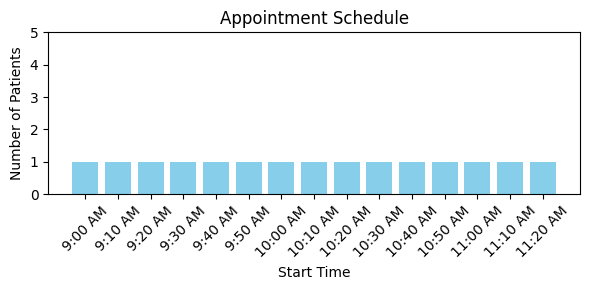

The expected waiting time is 14.29 minutes.
The expected makespan is 173.89 minutes.
The expected idle time is 23.89 minutes.
The expected lateness is 24.92 minutes.
The weighted objective value is 88.02
The difference in expected lateness between the schedules is 0.0 minutes. Thus, the lateness decreases.
The difference in expected waiting time between the schedules is 0.0 minutes. Thus, the waiting time increases.
The difference in expected makespan between the schedules is 0.0 minutes. Thus, the makespan decreases.
The difference in expected idle time between the schedules is 0.0 minutes. Thus, the idle time decreases.


In [7]:
# Redefine the schedule with a different number of patients in each slot such that it matches the Bailey Welch rule.
# Remember, there are 15 patients, 15 slots of 10 minutes each, and a service rate of 1/10.
# TODO: Define the Bailey Welch rule-based schedule as a dictionary.

x_t_bailey_welch= {1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1}
print(x_t_bailey_welch)

# Evaluate the Bailey Welch rule-based schedule.
plot_schedule(x_t_bailey_welch, start_times)
evaluate_schedule(x_t_bailey_welch, 15, 15, 10, 1/10, 1, 1, 2)

# Difference in lateness between the two schedules
lateness_diff = L(x_t_bailey_welch, 15, 15, 10, 1/10) - L(x_t, 15, 15, 10, 1/10)
print("The difference in expected lateness between the schedules is", round(lateness_diff, 2), "minutes. Thus, the lateness decreases.")

# Difference in waiting time between the two schedules
waiting_time_diff = W(x_t_bailey_welch, 15, 15, 10, 1/10)  - W(x_t, 15, 15, 10, 1/10) 
print("The difference in expected waiting time between the schedules is", round(waiting_time_diff, 2), "minutes. Thus, the waiting time increases.")  

# Difference in makespan between the two schedules
makespan_diff = M(x_t_bailey_welch, 15, 15, 10, 1/10) - M(x_t, 15, 15, 10, 1/10) 
print("The difference in expected makespan between the schedules is", round(makespan_diff, 2), "minutes. Thus, the makespan decreases.")

# Difference in idle time between the two schedules
idle_time_diff = I(x_t_bailey_welch, 15, 15, 10, 1/10) - I(x_t, 15, 15, 10, 1/10) 
print("The difference in expected idle time between the schedules is", round(idle_time_diff, 2), "minutes. Thus, the idle time decreases.")


2. **Fixed-Interval Scheduling:**  
   - **Task:** Create a schedule where **3 patients are scheduled every half an hour** (adjusting the slot length accordingly if necessary) and analyze the performance.
   - **Questions:**  
     - How does this scheduling rule affect the expected lateness compared to other strategies?
     - How do average waiting time and idle time compare?



{1: 3, 2: 0, 3: 0, 4: 3, 5: 0, 6: 0, 7: 3, 8: 0, 9: 0, 10: 3, 11: 0, 12: 0, 13: 3, 14: 0, 15: 0}


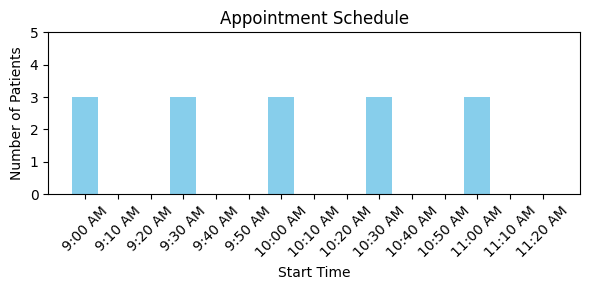

The expected waiting time is 20.54 minutes.
The expected makespan is 168.92 minutes.
The expected idle time is 18.92 minutes.
The expected lateness is 22.0 minutes.
The weighted objective value is 83.45
The difference in expected lateness between the schedules is -2.92 minutes. Thus, the lateness decreases.
The difference in expected waiting time between the schedules is 6.24 minutes. Thus, the waiting time increases.
The difference in expected idle time between the schedules is -4.97 minutes. Thus, the idle time decreases.


In [8]:
# Redefine the schedule such that there are three patients in every third slot.
# TODO: Define the new schedule as a dictionary.
x_t_half_hour ={1:3, 2:0, 3:0, 4:3,5:0, 6:0, 7:3, 8:0, 9:0, 10:3, 11:0, 12:0,13:3, 14:0, 15:0}
print(x_t_half_hour)
# Evaluate the Bailey Welch rule-based schedule.
plot_schedule(x_t_half_hour, start_times)
evaluate_schedule(x_t_half_hour, 15, 15, 10, 1/10, 1, 1, 2)

# Difference in lateness between the two schedules
lateness_diff = L(x_t_half_hour, 15, 15, 10, 1/10) - L(x_t, 15, 15, 10, 1/10)
print("The difference in expected lateness between the schedules is", round(lateness_diff, 2), "minutes. Thus, the lateness decreases.")

# Difference in waiting time between the two schedules
waiting_time_diff = W(x_t_half_hour, 15, 15, 10, 1/10)  - W(x_t, 15, 15, 10, 1/10) 
print("The difference in expected waiting time between the schedules is", round(waiting_time_diff, 2), "minutes. Thus, the waiting time increases.")  

# Difference in idle time between the two schedules
idle_time_diff = I(x_t_half_hour, 15, 15, 10, 1/10) - I(x_t, 15, 15, 10, 1/10) 
print("The difference in expected idle time between the schedules is", round(idle_time_diff, 2), "minutes. Thus, the idle time decreases.")


3. **Front-Loaded Scheduling:**  
   - **Task:** Develop a schedule where **all patients are scheduled to arrive at the beginning of the first interval** (i.e., the first slot receives all patients) and then no patients in later slots.
   - **Questions:**  
     - What is the impact on expected lateness, waiting time, and idle time when the schedule is front-loaded?
     - Discuss any practical implications of such a schedule.




{1: 15, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


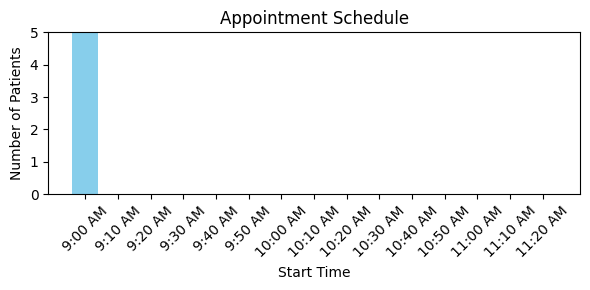

The expected waiting time is 70.0 minutes.
The expected makespan is 150.0 minutes.
The expected idle time is 0.0 minutes.
The expected lateness is 15.37 minutes.
The weighted objective value is 100.73
The difference in expected lateness between the schedules is -9.55 minutes. Thus, the lateness decreases.
The difference in expected waiting time between the schedules is 55.71 minutes. Thus, the waiting time increases.
The difference in expected idle time between the schedules is -23.89 minutes. Thus, the idle time decreases.


In [11]:
# Redefine the schedule such that there are three patients in every third slot.
# TODO: Define the new schedule as a dictionary.
x_t_all_at_once={t:0 for t in range(1,16)}
x_t_all_at_once[1]=15
print(x_t_all_at_once)
# Evaluate the Bailey Welch rule-based schedule.
plot_schedule(x_t_all_at_once, start_times)
evaluate_schedule(x_t_all_at_once, 15, 15, 10, 1/10, 1, 1, 2)

# Difference in lateness between the two schedules
lateness_diff = L(x_t_all_at_once, 15, 15, 10, 1/10) - L(x_t, 15, 15, 10, 1/10)
print("The difference in expected lateness between the schedules is", round(lateness_diff, 2), "minutes. Thus, the lateness decreases.")

# Difference in waiting time between the two schedules
waiting_time_diff = W(x_t_all_at_once, 15, 15, 10, 1/10)  - W(x_t, 15, 15, 10, 1/10) 
print("The difference in expected waiting time between the schedules is", round(waiting_time_diff, 2), "minutes. Thus, the waiting time increases.")  

# Difference in idle time between the two schedules
idle_time_diff = I(x_t_all_at_once, 15, 15, 10, 1/10) - I(x_t, 15, 15, 10, 1/10) 
print("The difference in expected idle time between the schedules is", round(idle_time_diff, 2), "minutes. Thus, the idle time decreases.")


4. **Varying Service Duration:**  
Consider again, the schedule `x_t` with 1 patient being scheduled at the beginning of each slot.
   - **Task:** Experiment with the service time parameter:
     - **Case A:** Reduce the expected service duration to 8 minutes (i.e., set μ = 1/8).
     - **Case B:** Increase the expected service duration to 12 minutes (i.e., set μ = 1/12).
   - **Questions:**  
     - How does changing the expected service duration affect the expected lateness?
     - What changes do you observe in the overall objective function, waiting time, and idle time?

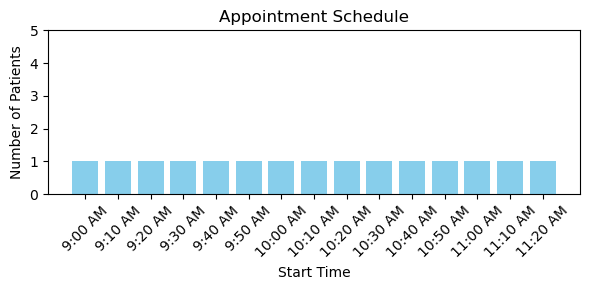

Default case, expected service duration is 10 minutes:
The expected waiting time is 14.29 minutes.
The expected makespan is 173.89 minutes.
The expected idle time is 23.89 minutes.
The expected lateness is 24.92 minutes.
The weighted objective value is 88.02


Case A: expected service duration decreases to 8 minutes:
The expected waiting time is 6.76 minutes.
The expected makespan is 157.96 minutes.
The expected idle time is 37.96 minutes.
The expected lateness is 10.18 minutes.
The weighted objective value is 65.08


Case B: expected service duration decreases to 12 minutes:
The expected waiting time is 24.2 minutes.
The expected makespan is 195.52 minutes.
The expected idle time is 15.52 minutes.
The expected lateness is 45.95 minutes.
The weighted objective value is 131.62


In [ ]:
# Evaluate the Bailey Welch rule-based schedule.
# TODO: Evaluate the original schedule using the evaluate_schedule functions with modified parameters.
